In [1]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
os.chdir('/content/drive/My Drive/DLM_data')

In [4]:
from utils.utils import split_dataset
from utils.evaluation import evaluate, get_binary_metrics

Using TensorFlow backend.


In [0]:
import neural_tangents as nt
from neural_tangents import stax
import numpy as np

import jax 

### Transplant 1col_concat

In [0]:
from jax import random
from neural_tangents import stax

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(2)
)

In [0]:
x_train,y_train,x_val,y_val,y_val_true,x_test,y_test,y_test_true, col = np.load('data/transplant_1col_concat.npy', allow_pickle=True)

x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])

In [8]:
x_train.shape,x_val.shape,x_test.shape

((297, 10820), (33, 10820), (33, 10820))

In [0]:
x_train = jax.numpy.array(x_train)
x_test = jax.numpy.array(x_test)
y_train = jax.numpy.array(y_train.astype(int).reshape(-1,1))
y_test = y_test.astype(int)

In [0]:
nb_classes = 2
targets = y_train.reshape(-1)
y_train_oh = np.eye(nb_classes)[targets]

In [11]:
%%time
nngp_mean, nngp_covariance = nt.predict.gp_inference(
    kernel_fn, x_train, y_train_oh, x_test, 
    diag_reg=1e-4, get='ntk', compute_cov=True)

#nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

ypred = nngp_mean.argmax(axis = 1)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 2.38 s, sys: 1.31 s, total: 3.69 s
Wall time: 12 s


In [12]:
evaluate(y_test,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.546992,0.554348,0.541667


In [13]:
get_binary_metrics(y_test,ypred)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


,recall,precision,f1-score
0,0.736842,0.608696,0.666667
1,0.357143,0.5,0.416667


In [14]:
np.mean(y_test)

0.42424242424242425

### Plot

In [0]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import confusion_matrix

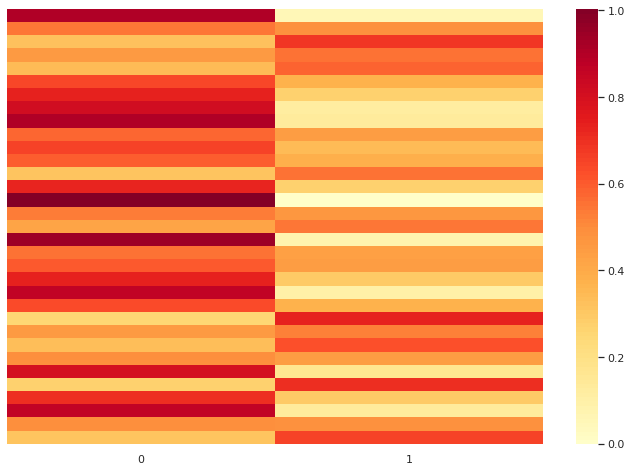

In [16]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(
            nngp_mean[y_test.argsort(),:],
            xticklabels=1,
            yticklabels=False,
            cmap=sns.color_palette("YlOrRd", 100)
           )

In [0]:
from collections import defaultdict
dic = defaultdict(list)
dic_mean = defaultdict(list)
for i, _ in enumerate(y_test):
    it = str(y_test[i])+','+str(ypred[i])
    if it in dic.keys():
        dic[it] += [nngp_std[i]]
    else:
        dic[it] = [nngp_std[i]]

heat_var = np.ones([2,2])*0.04
for k in dic.keys():
    i = int(list(k)[0])
    j = int(list(k)[2])
    heat_var[i,j] = np.mean(dic[k])

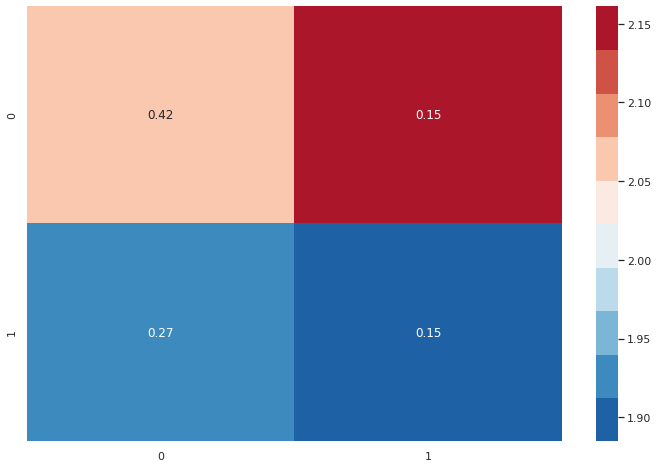

In [18]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(heat_var, cmap=sns.color_palette("RdBu_r",10), annot = confusion_matrix(y_test,ypred)/len(y_test))#, fmt='d')

# Transplant 1col

In [19]:
x_train,y_train,x_val,y_val,y_val_true,x_test,y_test,y_test_true, col = np.load('data/transplant_1col.npy', allow_pickle=True)

x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])

x_train.shape,x_val.shape,x_test.shape

((297, 1082), (33, 1082), (33, 1082))

In [0]:
x_train = jax.numpy.array(x_train)
x_test = jax.numpy.array(x_test)
y_train = jax.numpy.array(y_train.astype(int).reshape(-1,1))
y_test = y_test.astype(int)

nb_classes = 2
targets = y_train.reshape(-1)
y_train_oh = np.eye(nb_classes)[targets]

In [21]:
%%time
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(2)
)

nngp_mean, nngp_covariance = nt.predict.gp_inference(
    kernel_fn, x_train, y_train_oh, x_test, 
    diag_reg=1e-4, get='nngp', compute_cov=True)

nngp_std = np.sqrt(np.diag(nngp_covariance))

ypred = nngp_mean.argmax(axis = 1)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 610 ms, sys: 139 ms, total: 749 ms
Wall time: 794 ms


In [22]:
evaluate(y_test,ypred)

,accuracy,recall,precision,f1-score
0,0.606061,0.629699,0.636905,0.604608


In [23]:
get_binary_metrics(y_test,ypred)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


,recall,precision,f1-score
0,0.473684,0.75,0.580645
1,0.785714,0.52381,0.628571


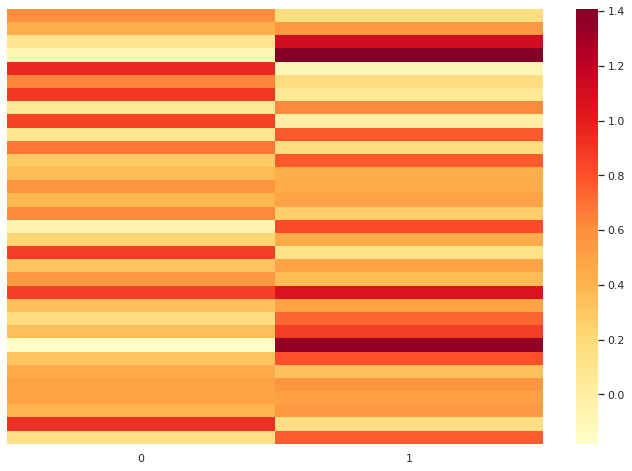

In [24]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(
            nngp_mean[y_test.argsort(),:],
            xticklabels=1,
            yticklabels=False,
            cmap=sns.color_palette("YlOrRd", 100)
           )

In [0]:
from collections import defaultdict
dic = defaultdict(list)
dic_mean = defaultdict(list)
for i, _ in enumerate(y_test):
    it = str(y_test[i])+','+str(ypred[i])
    if it in dic.keys():
        dic[it] += [nngp_std[i]]
    else:
        dic[it] = [nngp_std[i]]

heat_var = np.ones([2,2])*0.04
for k in dic.keys():
    i = int(list(k)[0])
    j = int(list(k)[2])
    heat_var[i,j] = np.mean(dic[k])

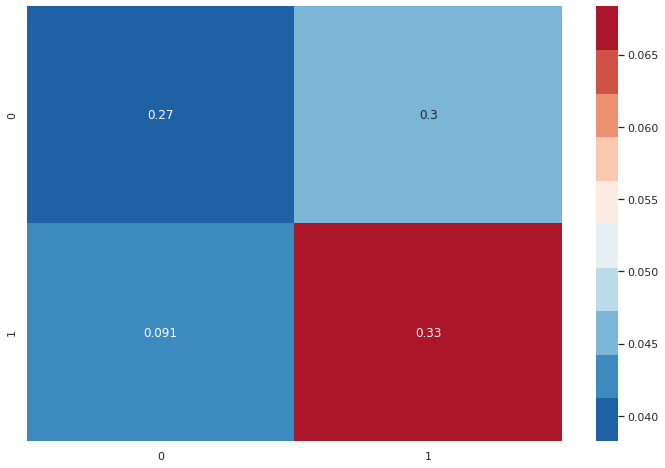

In [26]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(heat_var, cmap=sns.color_palette("RdBu_r",10), annot = confusion_matrix(y_test,ypred)/len(y_test))#, fmt='d')

# ECG 5000

In [27]:
x_train,y_train,x_val,y_val,x_test,y_test = np.load('data/ECG5000_full.npy', allow_pickle=True)

x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val]) - 1
y_test = y_test -1
x_train.shape,x_val.shape,x_test.shape

((4500, 140), (500, 140), (500, 140))

In [0]:
x_train = jax.numpy.array(x_train)
x_test = jax.numpy.array(x_test)
y_train = jax.numpy.array(y_train.astype(int).reshape(-1,1))
y_test = y_test.astype(int)

nb_classes = 5
targets = y_train.reshape(-1)
y_train_oh = np.eye(nb_classes)[targets]

In [29]:
%%time
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(2)
)

nngp_mean, nngp_covariance = nt.predict.gp_inference(
    kernel_fn, x_train, y_train_oh, x_test, 
    diag_reg=1e-4, get='nngp', compute_cov=True)

nngp_std = np.sqrt(np.diag(nngp_covariance))

ypred = nngp_mean.argmax(axis = 1)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 2.14 s, sys: 1.14 s, total: 3.29 s
Wall time: 7.45 s


In [30]:
evaluate(y_test,ypred)

,accuracy,recall,precision,f1-score
0,0.95,0.605535,0.64707,0.622633


In [31]:
get_binary_metrics(y_test,ypred)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


,recall,precision,f1-score
0,0.993151,0.989761,0.991453
1,0.966102,0.929348,0.947368
2,0.7,0.777778,0.736842
3,0.368421,0.538462,0.4375
4,0,0,0


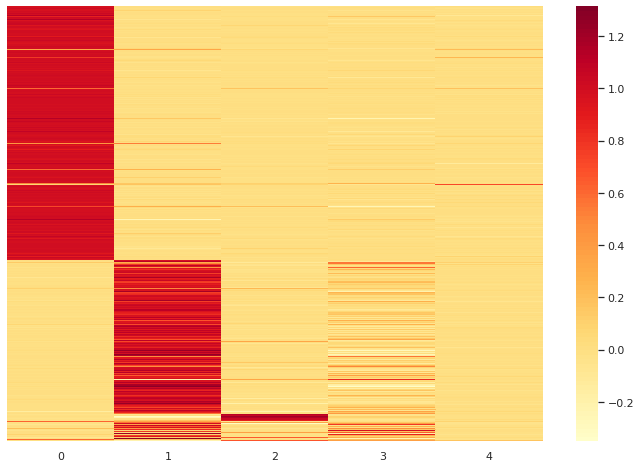

In [32]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(
            nngp_mean[y_test.argsort(),:],
            xticklabels=1,
            yticklabels=False,
            cmap=sns.color_palette("YlOrRd", 100)
           )

In [0]:
from collections import defaultdict
dic = defaultdict(list)
dic_mean = defaultdict(list)
for i, _ in enumerate(y_test):
    it = str(y_test[i])+','+str(ypred[i])
    if it in dic.keys():
        dic[it] += [nngp_std[i]]
    else:
        dic[it] = [nngp_std[i]]

heat_var = np.ones([5,5])*0.033
for k in dic.keys():
    i = int(list(k)[0])
    j = int(list(k)[2])
    heat_var[i,j] = np.mean(dic[k])

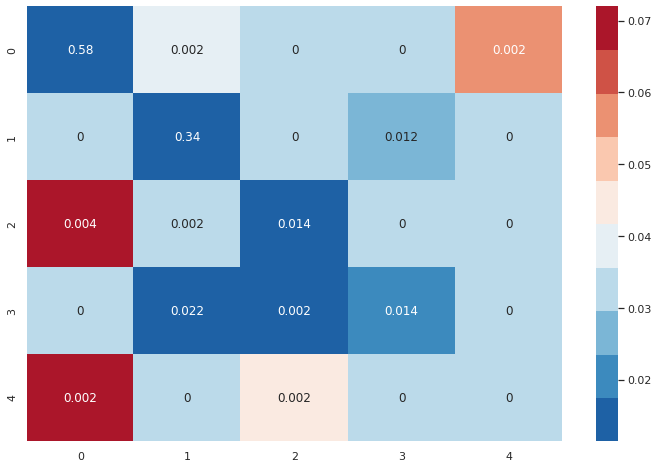

In [34]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(heat_var, cmap=sns.color_palette("RdBu_r",10), annot = confusion_matrix(y_test,ypred)/len(y_test))#, fmt='d')

# MIT-BIH


In [0]:
from utils.utils import read_dataset,split_dataset

In [0]:
data,labels = read_dataset('data/mitbih_train.csv','MIT-BIH')

In [37]:
nb_train = 10000 # max = 70043
nb_test = 17511 # max = 17511

x_train,y_train,x_val,y_val,y_val_true,x_test,y_test,y_test_true = split_dataset(data,labels)

x_train = np.concatenate([x_train, x_val])
y_train = np.concatenate([y_train, y_val])


x_train = jax.numpy.array(x_train[:nb_train,:])
x_test = jax.numpy.array(x_test[:nb_test,:])
y_train = jax.numpy.array(y_train[:nb_train,:].astype(int))
y_test = y_test[:nb_test,:].astype(int)
y_test_true = y_test_true[:nb_test].astype(int)

x_train.shape, x_test.shape

((10000, 187), (17511, 187))

In [38]:
%%time
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(5)
)

nngp_mean, nngp_covariance = nt.predict.gp_inference(
    kernel_fn, x_train, y_train, x_test, 
    diag_reg=1e-4, get='nngp', compute_cov=True)

nngp_std = np.sqrt(np.diag(nngp_covariance))

ypred = nngp_mean.argmax(axis = 1)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


CPU times: user 12.5 s, sys: 7.15 s, total: 19.7 s
Wall time: 24.4 s


In [39]:
evaluate(y_test_true,ypred)

,accuracy,recall,precision,f1-score
0,0.971618,0.820816,0.916205,0.862959


In [40]:
get_binary_metrics(y_test_true,ypred)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


,recall,precision,f1-score
0,0.993929,0.975489,0.984623
1,0.660674,0.890909,0.75871
2,0.878133,0.942486,0.909172
3,0.625,0.784314,0.695652
4,0.946345,0.987825,0.96664


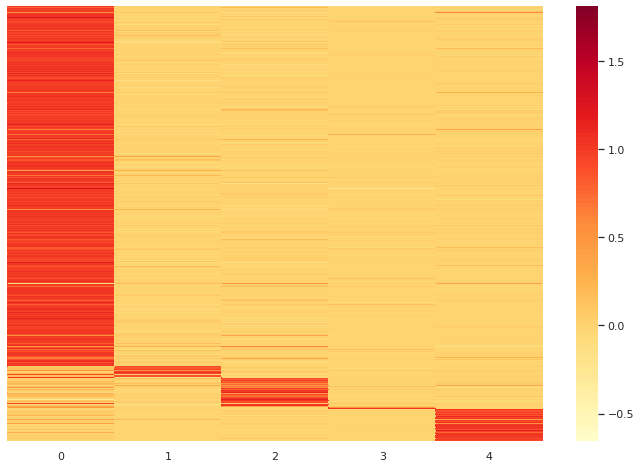

In [41]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(
            nngp_mean[y_test_true.argsort(),:],
            xticklabels=1,
            yticklabels=False,
            cmap=sns.color_palette("YlOrRd", 100)
           )

In [0]:
from collections import defaultdict
dic = defaultdict(list)
dic_mean = defaultdict(list)
for i, _ in enumerate(y_test):
    it = str(y_test_true[i])+','+str(ypred[i])
    if it in dic.keys():
        dic[it] += [nngp_std[i]]
    else:
        dic[it] = [nngp_std[i]]

heat_var = np.ones([5,5])*0.006
for k in dic.keys():
    i = int(list(k)[0])
    j = int(list(k)[2])
    heat_var[i,j] = np.mean(dic[k])

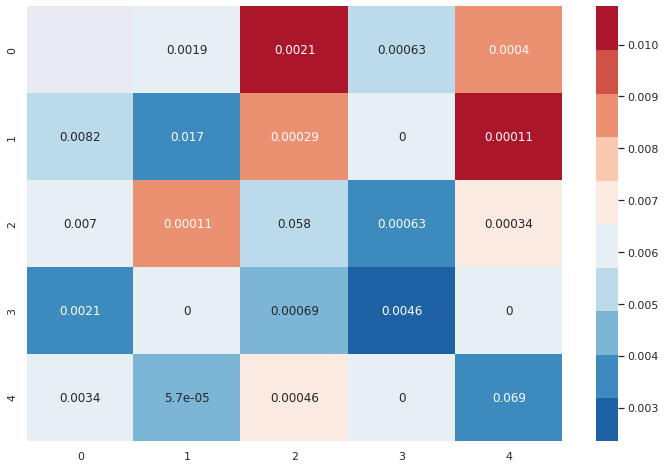

In [43]:
rcParams['figure.figsize'] = 12,8
sns.heatmap(heat_var, cmap=sns.color_palette("RdBu_r",10), annot = confusion_matrix(y_test_true,ypred)/len(y_test_true))

In [44]:
np.mean(y_test, axis=0)

array([0.8277654 , 0.0254126 , 0.06607275, 0.00730969, 0.07343955])

In [45]:
confusion_matrix(y_test_true,ypred)/len(y_test_true)

array([[8.22739992e-01, 1.88452972e-03, 2.11295757e-03, 6.28176575e-04,
        3.99748729e-04],
       [8.22340243e-03, 1.67894466e-02, 2.85534807e-04, 0.00000000e+00,
        1.14213923e-04],
       [6.96704928e-03, 1.14213923e-04, 5.80206727e-02, 6.28176575e-04,
        3.42641768e-04],
       [2.05585061e-03, 0.00000000e+00, 6.85283536e-04, 4.56855691e-03,
        0.00000000e+00],
       [3.42641768e-03, 5.71069613e-05, 4.56855691e-04, 0.00000000e+00,
        6.94991719e-02]])